In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Data Preprocessing

We read in 15 years of OM2.5 data and create the time series of air-pollution index. This section of code only need to be run once, and the results is output to `data/apts_2000_2014.csv`

## Remove Heading Years for High Proportion of Missing Data

From looking into the raw data, we knew that in the early years there are only a few stations having PM2.5 observations. Since this fact would cause low index values, we better remove these days and only use the more reliable index data.

```
aptsm = apts.mean(axis=1)
plt.figure(figsize=(16,4))
plt.plot(np.array(aptsm))
plt.show()
```
<img src='figures/apts_2000_2015.png' />

```
print(aptsm.index[1500])
print(aptsm.index[1817])
print(aptsm.index[2000])
```

**Output:**
```
2004-02-19:h23
2005-01-01:h23
2005-07-03:h23
```

From the figures above, we can see the values of the index became stable around the 1500th record, so we keep the data after 2005-01-01 (the 1817th record) for further analysis.

```
apts = apts.iloc[1817:,:]
apts.to_csv('../data/apts_2005_2014.csv')
apts.shape

(3652, 240)
```

## Clustering

We want to check again which type of event we want to predict. Let's start with a larger number of clusters and then decrease the value to see if the clusters are stable.

[1274  459 1508  230  181]


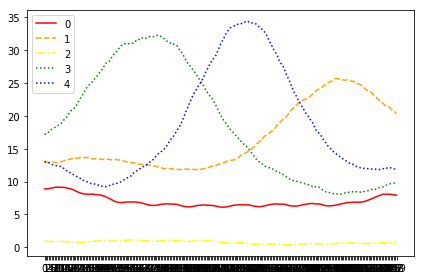

In [2]:
apts = pd.read_csv('../data/apts_2005_2014.csv', index_col=0)

from sklearn.cluster import AgglomerativeClustering

ncluster = 5

hc = AgglomerativeClustering(n_clusters=ncluster, affinity='euclidean', linkage='ward')  
hc.fit_predict(apts) 

print(np.bincount(hc.labels_))

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
styles = ['solid', 'dashed','dashdot','dotted',':']
for i in range(ncluster):
    plt.plot(apts.iloc[hc.labels_==i,:].mean(axis=0), label=i, ls=styles[i], c=colors[i])
plt.legend()
plt.tight_layout()
plt.show()

[ 870 1274 1508]


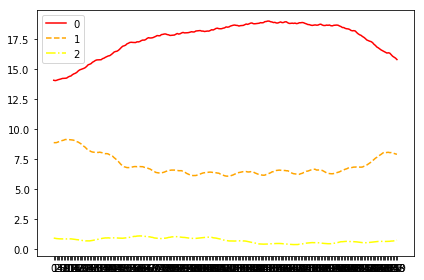

In [3]:
ncluster = 3

hc = AgglomerativeClustering(n_clusters=ncluster, affinity='euclidean', linkage='ward')  
hc.fit_predict(apts) 

print(np.bincount(hc.labels_))

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
styles = ['solid', 'dashed','dashdot','dotted',':']
for i in range(ncluster):
    plt.plot(apts.iloc[hc.labels_==i,:].mean(axis=0), label=i, ls=styles[i], c=colors[i])
plt.legend()
plt.tight_layout()
plt.show()

As shown above, the two events, 'low'(1274/3625) and 'very low'(1508/3625) are fairly stable when we adjust the number of clusters, and hence we can see the all rest as the air-pollution event we want to detect (so that we can have more cases).

In [4]:
# Y = {1: hc.labels_==0, 0: otherwise}
Y = (hc.labels_==0)*1
Y = np.array(Y).reshape(len(Y),1)
print(Y.shape)

(3652, 1)


# Use Weather Events as Predictors

Now we have Y, and next we need a set of X. Let's use the weather event labels.

In [5]:
# Read weather events
events = pd.read_csv('../data/all_events_2000-2015.csv')
print(events.shape)
print(events.head())
# Sum up events every 10 days
evsum = []
for i in np.arange(10, events.shape[0]):
    tmp = events.iloc[(i-10):i,1:].sum(axis=0)
    evsum.append(tmp)
# Add date
evsum = pd.DataFrame(evsum)
evsum.index = list(events['yyyymmdd'])[10:]
evsum.index = evsum.index.map(str)
# Check
print(evsum.shape)
evsum.head()

(5844, 14)
   yyyymmdd  CS  FT  NE  SNE  SWF  SSWF  TYW  TC100  TC200  TC300  TC500  \
0  20000101   0   0   0    0    0     0    0      0      0      0      0   
1  20000102   0   0   1    0    0     0    0      0      0      0      0   
2  20000103   0   0   0    0    0     0    0      0      0      0      0   
3  20000104   0   0   0    0    0     0    0      0      0      0      0   
4  20000105   0   0   0    0    0     0    0      0      0      0      0   

   TC1000  NWPTY  
0       0      0  
1       0      0  
2       0      0  
3       0      0  
4       0      0  
(5834, 13)


,CS,FT,NE,SNE,SWF,SSWF,TYW,TC100,TC200,TC300,TC500,TC1000,NWPTY
20000111,0,1,5,3,0,0,0,0,0,0,0,0,0
20000112,0,1,5,3,0,0,0,0,0,0,0,0,0
20000113,0,1,4,3,0,0,0,0,0,0,0,0,0
20000114,0,1,5,4,0,0,0,0,0,0,0,0,0
20000115,0,1,6,5,0,0,0,0,0,0,0,0,0


In [6]:
apdates = [d.replace('-','')[:8] for d in list(apts.index)]
apevents = pd.DataFrame({'ap':Y.flatten()}, index=apdates)
print(apevents.shape)
apevents.head()

(3652, 1)


,ap
20050101,0
20050102,0
20050103,0
20050104,0
20050105,0


In [7]:
evsum.loc[apevents.index,:].head()

,CS,FT,NE,SNE,SWF,SSWF,TYW,TC100,TC200,TC300,TC500,TC1000,NWPTY
20050101,1,1,5,4,0,0,0,0,0,0,0,0,2
20050102,2,1,6,5,0,0,0,0,0,0,0,0,1
20050103,2,1,5,4,0,0,0,0,0,0,0,0,0
20050104,2,1,4,3,0,0,0,0,0,0,0,0,0
20050105,2,1,4,3,0,0,0,0,0,0,0,0,0


In [8]:
apevents.to_csv('../data/ap_events_2005-2014.csv')
evsum.loc[apevents.index,:].to_csv('../data/weather_event_10day_sums_2005-2014.csv')

Now we have the X and Y aligned with the time-stamp and saved in `weather_event_10day_sums_2005-2014.csv` / `ap_events_2005-2014.csv`.

## Cross Validation with `sklearn`

Cross validation involves random sampling and splitting your data. The package [`scilit-learn`](https://scikit-learn.org/stable/modules/cross_validation.html) provides a list of tools for this purpose in [`sklearn.model_selection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection). Let's see some examples:

In [11]:
# Load data
y = pd.read_csv('../data/ap_events_2005-2014.csv',  index_col=0)
x = pd.read_csv('../data/weather_event_10day_sums_2005-2014.csv', index_col=0)

In [12]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

kf = KFold(n_splits=5)
for train_indices, test_indices in kf.split(apevents):
    print('Train: %s | test: %s | Y=1: %s' % (len(train_indices), len(test_indices), float(y.iloc[test_indices,:].mean())))

Train: 2921 | test: 731 | Y=1: 0.332421340629275
Train: 2921 | test: 731 | Y=1: 0.34610123119015046
Train: 2922 | test: 730 | Y=1: 0.25068493150684934
Train: 2922 | test: 730 | Y=1: 0.12876712328767123
Train: 2922 | test: 730 | Y=1: 0.13287671232876713


In [17]:
skf = StratifiedKFold(n_splits=5)
for train_indices, test_indices in skf.split(X=x,y=np.array(y).flatten()):
    print('Train: %s | test: %s | Y=1: %s' % (len(train_indices), len(test_indices), float(y.iloc[test_indices,:].mean())))

Train: 2921 | test: 731 | Y=1: 0.23803009575923392
Train: 2921 | test: 731 | Y=1: 0.23803009575923392
Train: 2922 | test: 730 | Y=1: 0.23835616438356164
Train: 2922 | test: 730 | Y=1: 0.23835616438356164
Train: 2922 | test: 730 | Y=1: 0.23835616438356164


As shown above, the [`sklearn.model_selection.StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) gives a more balanced sampling results on y, so that the training/testing will be more stable when y is skewly distributed.

The method [`sklearn.model_selection.cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) provides a quick way to calculate the *out-of-sample* evaluations with crossvalidation. Let's use GLM as an example.

In [32]:
from sklearn import linear_model, metrics
# Initialize the GLM
glm = linear_model.LogisticRegression(C=1e5, solver='lbfgs', max_iter=500)
# Fit and see in-sample error
glm.fit(x, np.array(y).flatten())
print('In-sample accuracy:')
print(glm.score(x, np.array(y).flatten()))

scores_kf = cross_val_score(glm, x, np.array(y).flatten(), cv=kf)
scores_skf = cross_val_score(glm, x, np.array(y).flatten(), cv=skf)
print('CV accuracy:')
print('  5-fold CV:')
print({'acc':scores_kf, 'mean':scores_kf.mean(), 'std':scores_kf.std()})
print('  Stratified 5-fold CV:')
print({'acc':scores_skf, 'mean':scores_skf.mean(), 'std':scores_skf.std()})

In-sample accuracy:
0.7691675794085433
CV accuracy:
  5-fold CV:
{'acc': array([0.68125855, 0.67031464, 0.7630137 , 0.79178082, 0.80273973]), 'mean': 0.7418214867979687, 'std': 0.055564693285606176}
  Stratified 5-fold CV:
{'acc': array([0.75239398, 0.77428181, 0.74520548, 0.73013699, 0.77123288]), 'mean': 0.7546502258118921, 'std': 0.016465576382354755}
